<a href="https://colab.research.google.com/github/atosiroy/CV_Tirana/blob/main/M3_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PART 1: Object recognition using regional properties

1. Generation of the sample image:

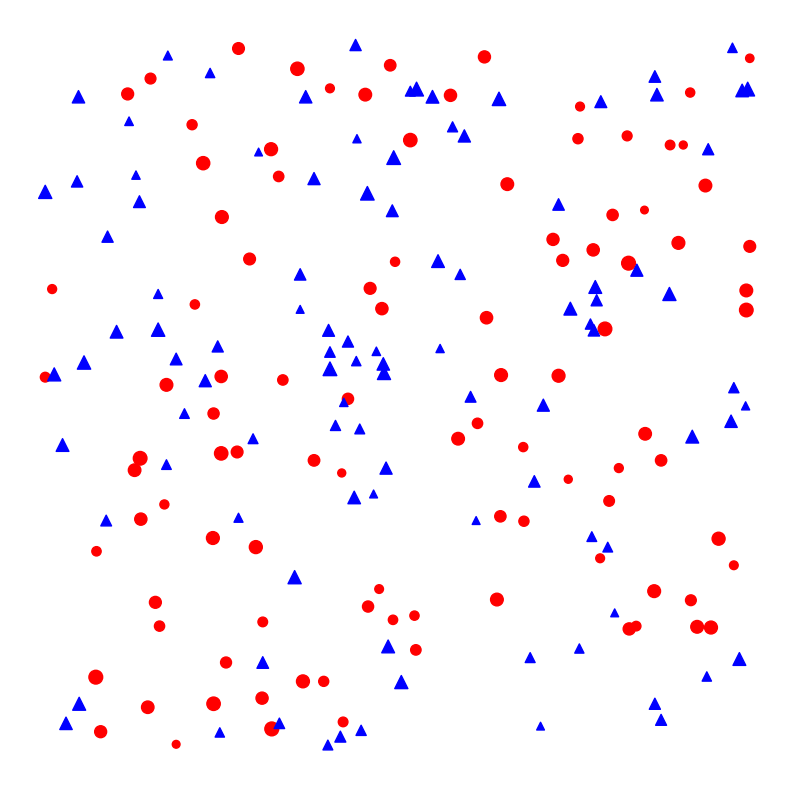

In [3]:
import numpy as np
np.random.seed(13)

import matplotlib.pyplot as plt
Isize = 1024
N = 100

X = np.random.randint(Isize, size=(2,2*N)) # random placement of objects

fig = plt.figure(figsize=(10,10))
symsizes1 = np.random.randint(30,100,size=(1,N))
symsizes2 = np.random.randint(30,100,size=(1,N))
plt.scatter(X[0,0:N], X[1,0:N], s=symsizes1, c='r',edgecolor="red",marker = 'o')
plt.scatter(X[0,N:2*N], X[1,N:2*N], s=symsizes2, c='b',edgecolor="blue",marker = '^')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/UPT/CV/Patterns_result.png',dpi=600, facecolor='w',bbox_inches='tight')
plt.show()

Reading the image:

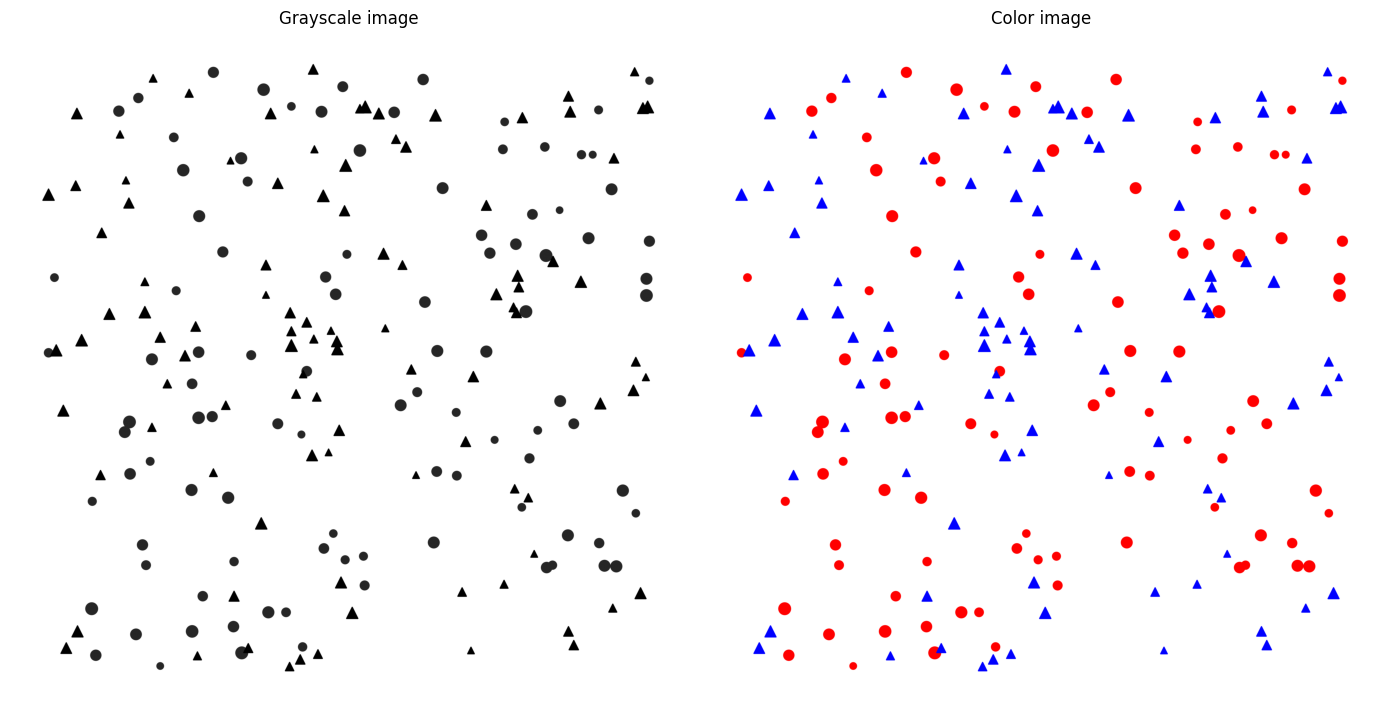

In [4]:
import matplotlib.pyplot as plt
from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.measure import label

I = io.imread('/content/drive/MyDrive/UPT/CV/Patterns_result.png',as_gray=True) # read image as grayscale (no color information)
IC = io.imread('/content/drive/MyDrive/UPT/CV/Patterns_result.png') # read image as color (to define object class labels: triangle, circle)

fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(I,cmap=plt.cm.gray)
ax[0].set_title('Grayscale image')
ax[1].imshow(IC,cmap=plt.cm.jet)
ax[1].set_title('Color image') # set figure title

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()


2. Segmentation and regional features:


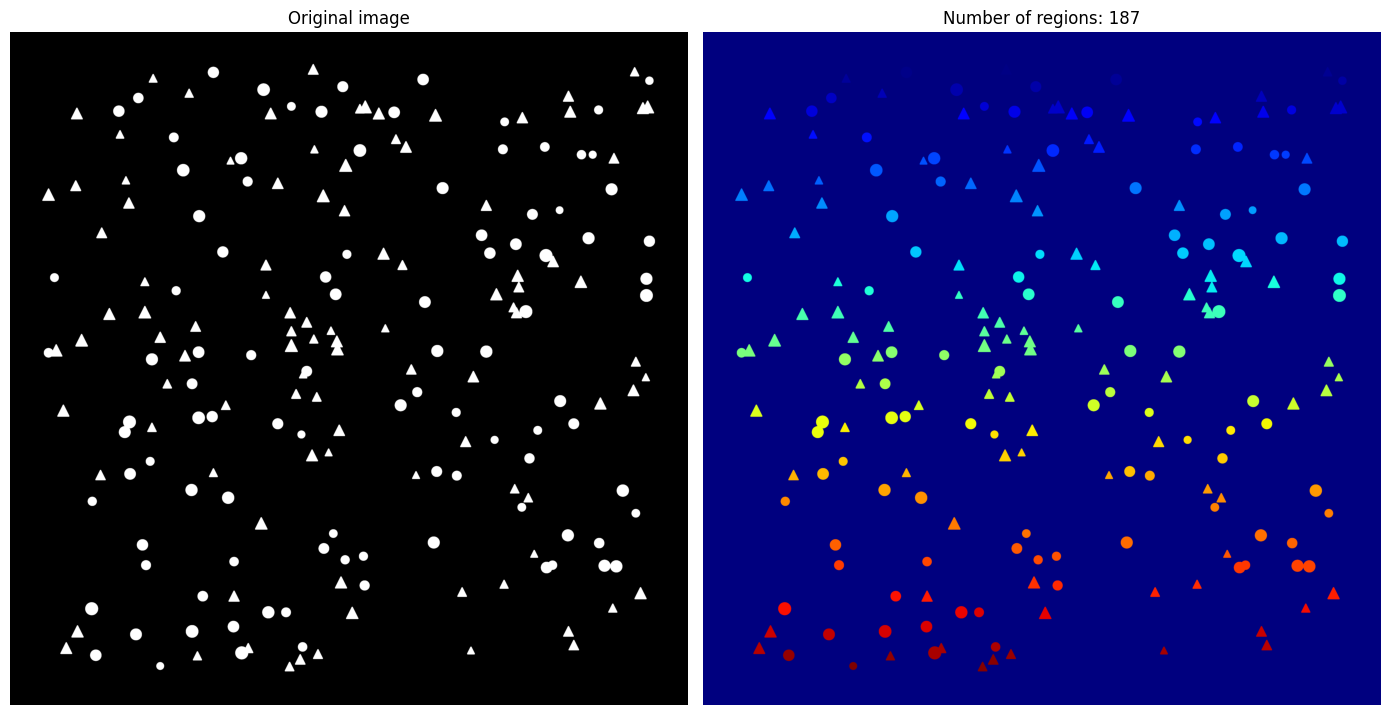

In [5]:
bw = np.logical_not(I==1)# Set regions white and background black
# label image regions:
label_image, nregions = label(bw,return_num=True)

# Segmentation figure:
fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(bw,cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

# Get regional properties:
from skimage.measure import regionprops
props = regionprops(label_image)

# Get relevant features (eccentricity and area, for instance)
features = np.zeros((nregions,3))
labels = np.zeros(nregions)
# Save class label of each object (1: triangle, 2:circle)
bw1 = np.array(IC[:,:,0]==0,dtype=np.uint8)
bw2 = np.array(IC[:,:,2]==0,dtype=np.uint8)

for i in range(0, nregions):
    features[i, 0] = props[i].eccentricity
    features[i, 1] = props[i].area
    features[i, 2] = props[i].solidity

    # Get centroid coordinates and ensure they are within bounds
    row = int(props[i].centroid[0])
    col = int(props[i].centroid[1])
    row = min(max(0, row), bw1.shape[0] - 1)  # Clamp row to valid range
    col = min(max(0, col), bw1.shape[1] - 1)  # Clamp col to valid range

labels[i] = bw1[row, col] + 2 * bw2[row, col]

**3. Exploratory analysis of features:**

A scatterplot of features shows that circles present low eccentricity whereas triangles present eccentricity around 0.5. There are some observations with higher eccentricities due to the overlaping cases between triangles and circles.

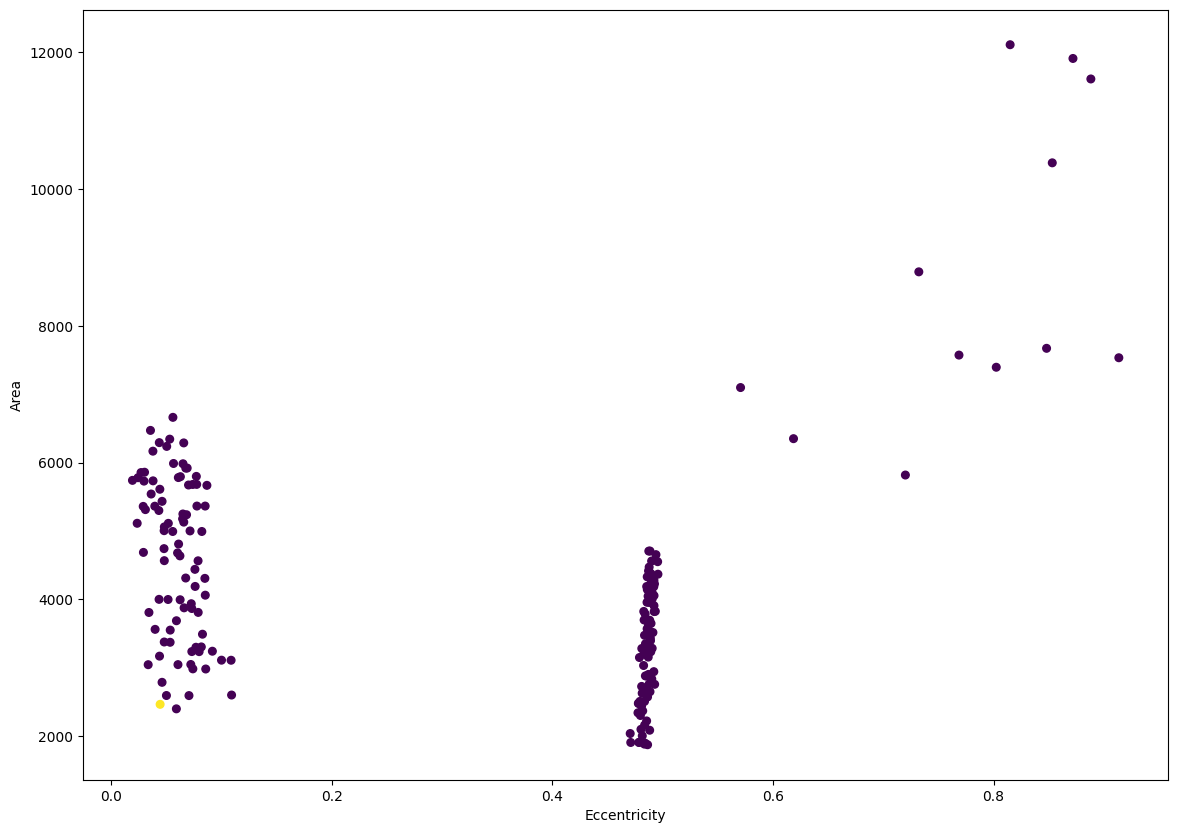

In [6]:
fig = plt.figure(figsize=(14,10))
plt.scatter(features[:,0], features[:,1], s=30, c=labels,marker = 'o')
plt.xlabel('Eccentricity')
plt.ylabel('Area')
plt.show()

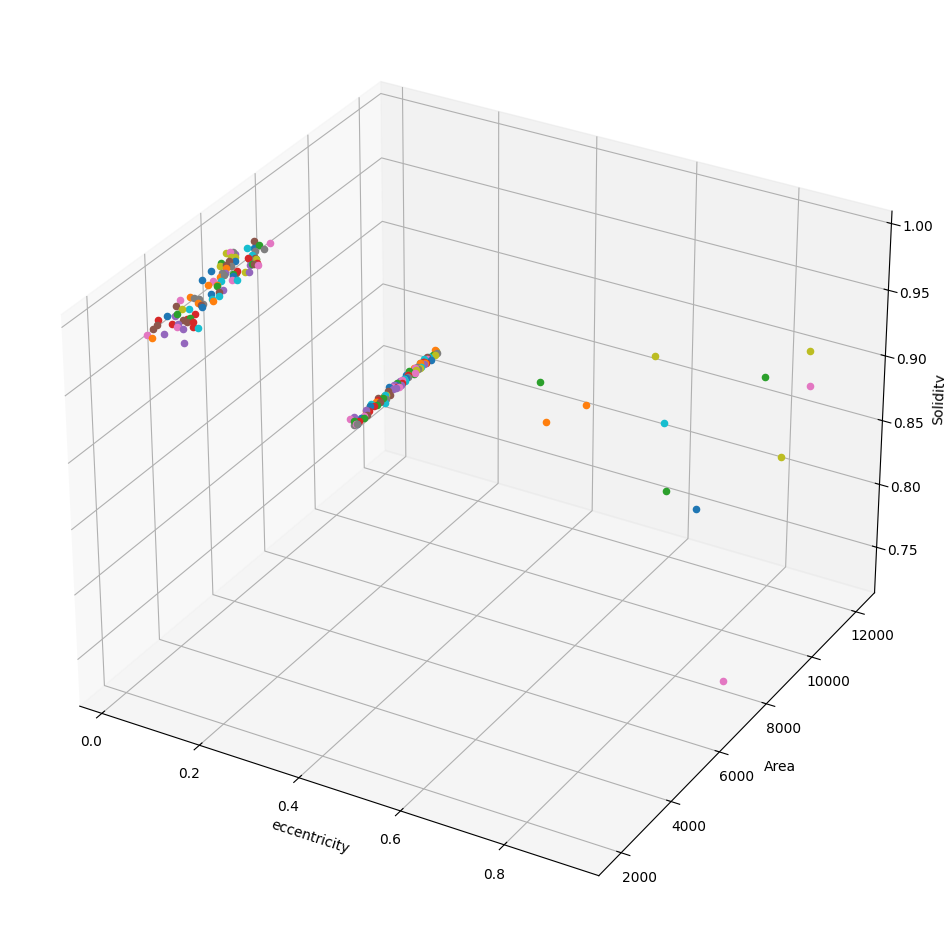

In [7]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for k in range(features.shape[0]):
    xs = features[k,0]
    ys = features[k,1]
    zs = features[k,2]
    ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('eccentricity')
ax.set_ylabel('Area')
ax.set_zlabel('Solidity')

plt.show()

4. Fit Linear Discriminant Analysis (LDA):

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

NTRAIN = 50 # Train with NTRAIN objects

clf = LinearDiscriminantAnalysis()
clf.fit(features[0:NTRAIN,:], labels[0:NTRAIN])

LinearDiscriminantAnalysis()

In [9]:
labels_pred = clf.predict(features[NTRAIN+1:-1])
labels_true = labels[NTRAIN+1:-1]

In [10]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(labels_true,labels_pred)
CM

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


array([[135]])

In [11]:
from sklearn.metrics import classification_report
print(classification_report(labels_true,labels_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       135

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135



PART 2: EXTRACTION OF REGIONAL ATTRIBUTES


Quantitative characterization of an image requires the extraction of relevant regional properties of the image. This process is known as feature extraction.

There are several feature extraction apporoaches and in this session we are going to cover the most important ones:

Basic regional properties: Based on region shape, intensity, color, size, etc.

Advanced regional properties (texture analysis): Based on statistical properties of the distribution of pixels in the region: Homogeneity, entropy, uniformity, etc.



Basic regional properties

1. Start from labelled image (segmented regions):

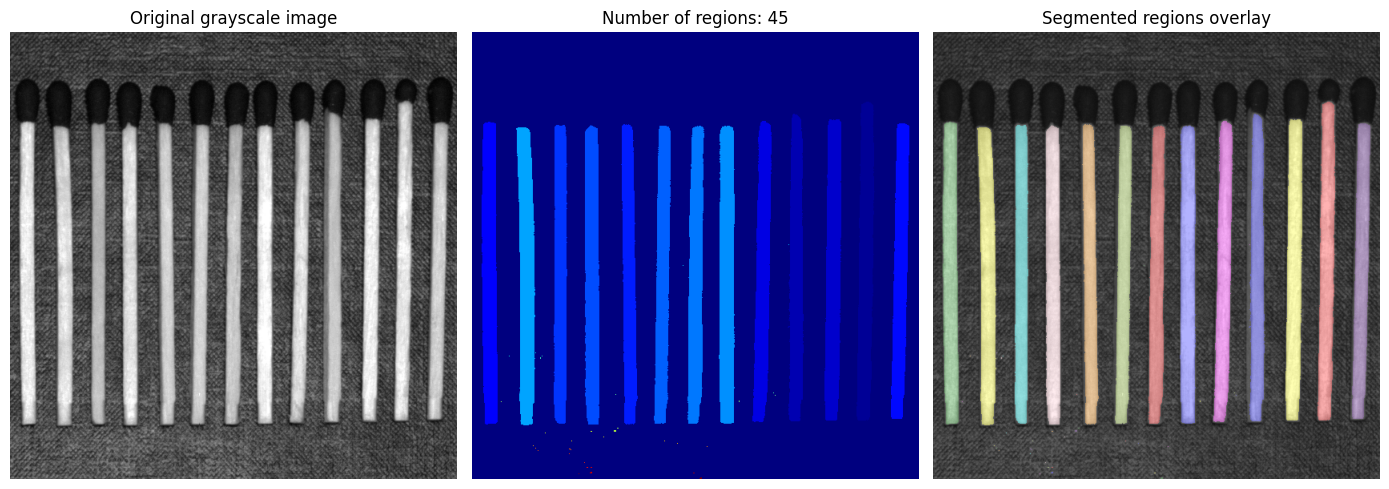

In [13]:
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb

I = sk.io.imread('/content/drive/MyDrive/UPT/TiranaCV2025/matches.tif') # read image using imread function

# If the image is grayscale:
# IG = I
# If the image has a single channel:
IG = I.squeeze()

# Apply Otsu threshold for segmentation :
thresh = threshold_otsu(IG)
bw = IG > thresh # keep lighter regions with grayscale intensities above threshold

# label image regions:
label_image, nregions = label(bw,return_num=True)
image_label_overlay = label2rgb(label_image, image=IG)

# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(IG,cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image')
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[2].imshow(image_label_overlay,cmap=plt.cm.jet)
ax[2].set_title('Segmented regions overlay')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

2. Obtain regional properties:

In [14]:
from skimage.measure import regionprops
import numpy as np

props = regionprops(label_image)

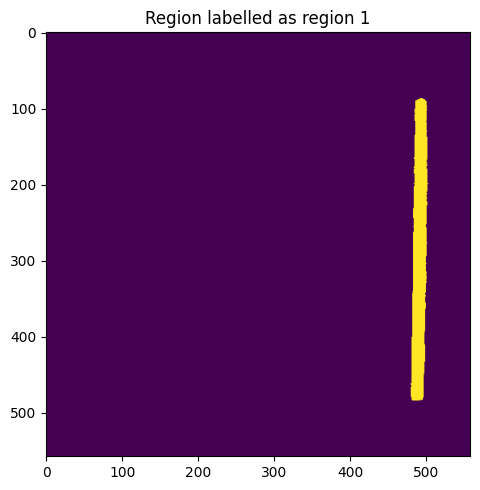

Area of Region 1: 6735.0 pixels
Centroiod of Region 1: (np.float64(287.79346696362285), np.float64(491.1221974758723)) 
Eccentricity of Region 1: 0.9990421943253247
Major Axis Length of Region 1: 450.74131008126204 pixels
Minor Axis Length of Region 1: 19.7231848940344 pixels
Perimeter of Region 1: 849.8650070512055 pixels
Orientation of Region 1: -0.013151214600322376 degrees


In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(label_image==1)
ax.set_title('Region labelled as region 1') # set figure title
plt.tight_layout()
plt.show()

print('Area of Region 1: {} pixels'.format(props[0].area))
print('Centroiod of Region 1: {} '.format(props[0].centroid))
print('Eccentricity of Region 1: {}'.format(props[0].eccentricity))
print('Major Axis Length of Region 1: {} pixels'.format(props[0].major_axis_length))
print('Minor Axis Length of Region 1: {} pixels'.format(props[0].minor_axis_length))
print('Perimeter of Region 1: {} pixels'.format(props[0].perimeter))
print('Orientation of Region 1: {} degrees'.format(props[0].orientation))

3. Inspection of the regions:

There are clearly too many regions (45), we shoud discard those correspoding to little sporious artefacts in the image. This becomes evident when we print the area itereting over regions. Note that the region number 1 is saved in props[0].

In [16]:
for ireg in range(0,nregions):
    print('Area of region {} is = {} pixels'.format(ireg+1, props[ireg].area))

Area of region 1 is = 6735.0 pixels
Area of region 2 is = 5936.0 pixels
Area of region 3 is = 6615.0 pixels
Area of region 4 is = 6184.0 pixels
Area of region 5 is = 6567.0 pixels
Area of region 6 is = 6004.0 pixels
Area of region 7 is = 5687.0 pixels
Area of region 8 is = 5600.0 pixels
Area of region 9 is = 6323.0 pixels
Area of region 10 is = 5827.0 pixels
Area of region 11 is = 6103.0 pixels
Area of region 12 is = 6637.0 pixels
Area of region 13 is = 6629.0 pixels
Area of region 14 is = 1.0 pixels
Area of region 15 is = 1.0 pixels
Area of region 16 is = 1.0 pixels
Area of region 17 is = 1.0 pixels
Area of region 18 is = 1.0 pixels
Area of region 19 is = 2.0 pixels
Area of region 20 is = 1.0 pixels
Area of region 21 is = 1.0 pixels
Area of region 22 is = 1.0 pixels
Area of region 23 is = 2.0 pixels
Area of region 24 is = 1.0 pixels
Area of region 25 is = 2.0 pixels
Area of region 26 is = 6.0 pixels
Area of region 27 is = 2.0 pixels
Area of region 28 is = 1.0 pixels
Area of region 29 

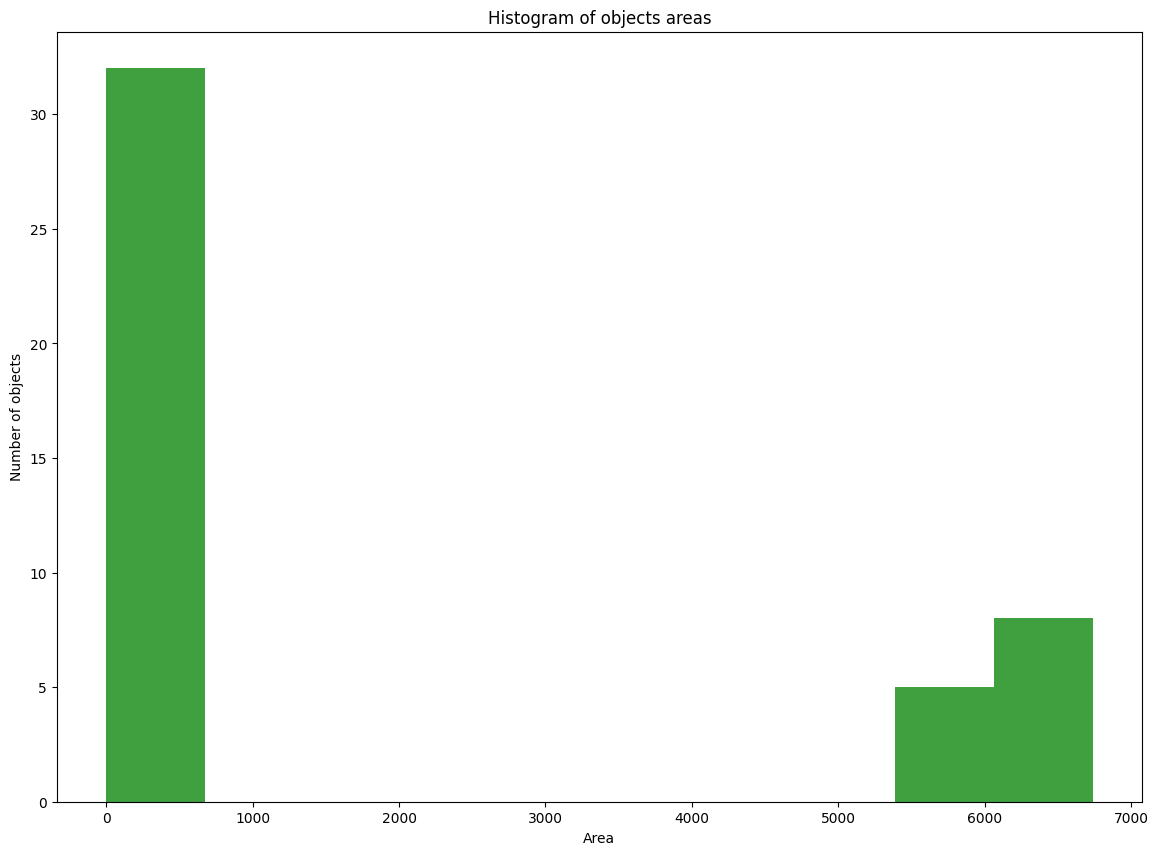

In [17]:
import numpy as np

area = np.zeros(nregions)
for i in range(0,nregions):
    area[i] = props[i].area

# Plot histogram of the areas
fig = plt.figure(figsize=(14, 10))
n, bins, patches = plt.hist(area, density=False, facecolor='g', alpha=0.75)

plt.xlabel('Area')
plt.ylabel('Number of objects')
plt.title('Histogram of objects areas')
plt.show()


In [18]:
ind_large = np.where(area > 3000)
ind_lregions = np.array(ind_large)+1 #Note: region 1 is placed in component 0 or the props variable
area_large = area[ind_large]
print('There are {} large objects'.format(len(area_large)))
print('Large objects correspond to regions: {}'.format(ind_lregions))
print('The areas of the large objects are: {}'.format(area_large))

ind_small = np.where(area < 3000)
area_small = area[ind_small]
ind_sregions = np.array(ind_small)+1
print('There are {} small objects'.format(len(area_small)))
print('Small objects correspond to regions: {}'.format(ind_sregions))
print('The areas of the small objects are {}'.format(area_small))

There are 13 large objects
Large objects correspond to regions: [[ 1  2  3  4  5  6  7  8  9 10 11 12 13]]
The areas of the large objects are: [6735. 5936. 6615. 6184. 6567. 6004. 5687. 5600. 6323. 5827. 6103. 6637.
 6629.]
There are 32 small objects
Small objects correspond to regions: [[14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
  38 39 40 41 42 43 44 45]]
The areas of the small objects are [1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 2. 6. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1.
 1. 1. 2. 2. 5. 2. 1. 5.]


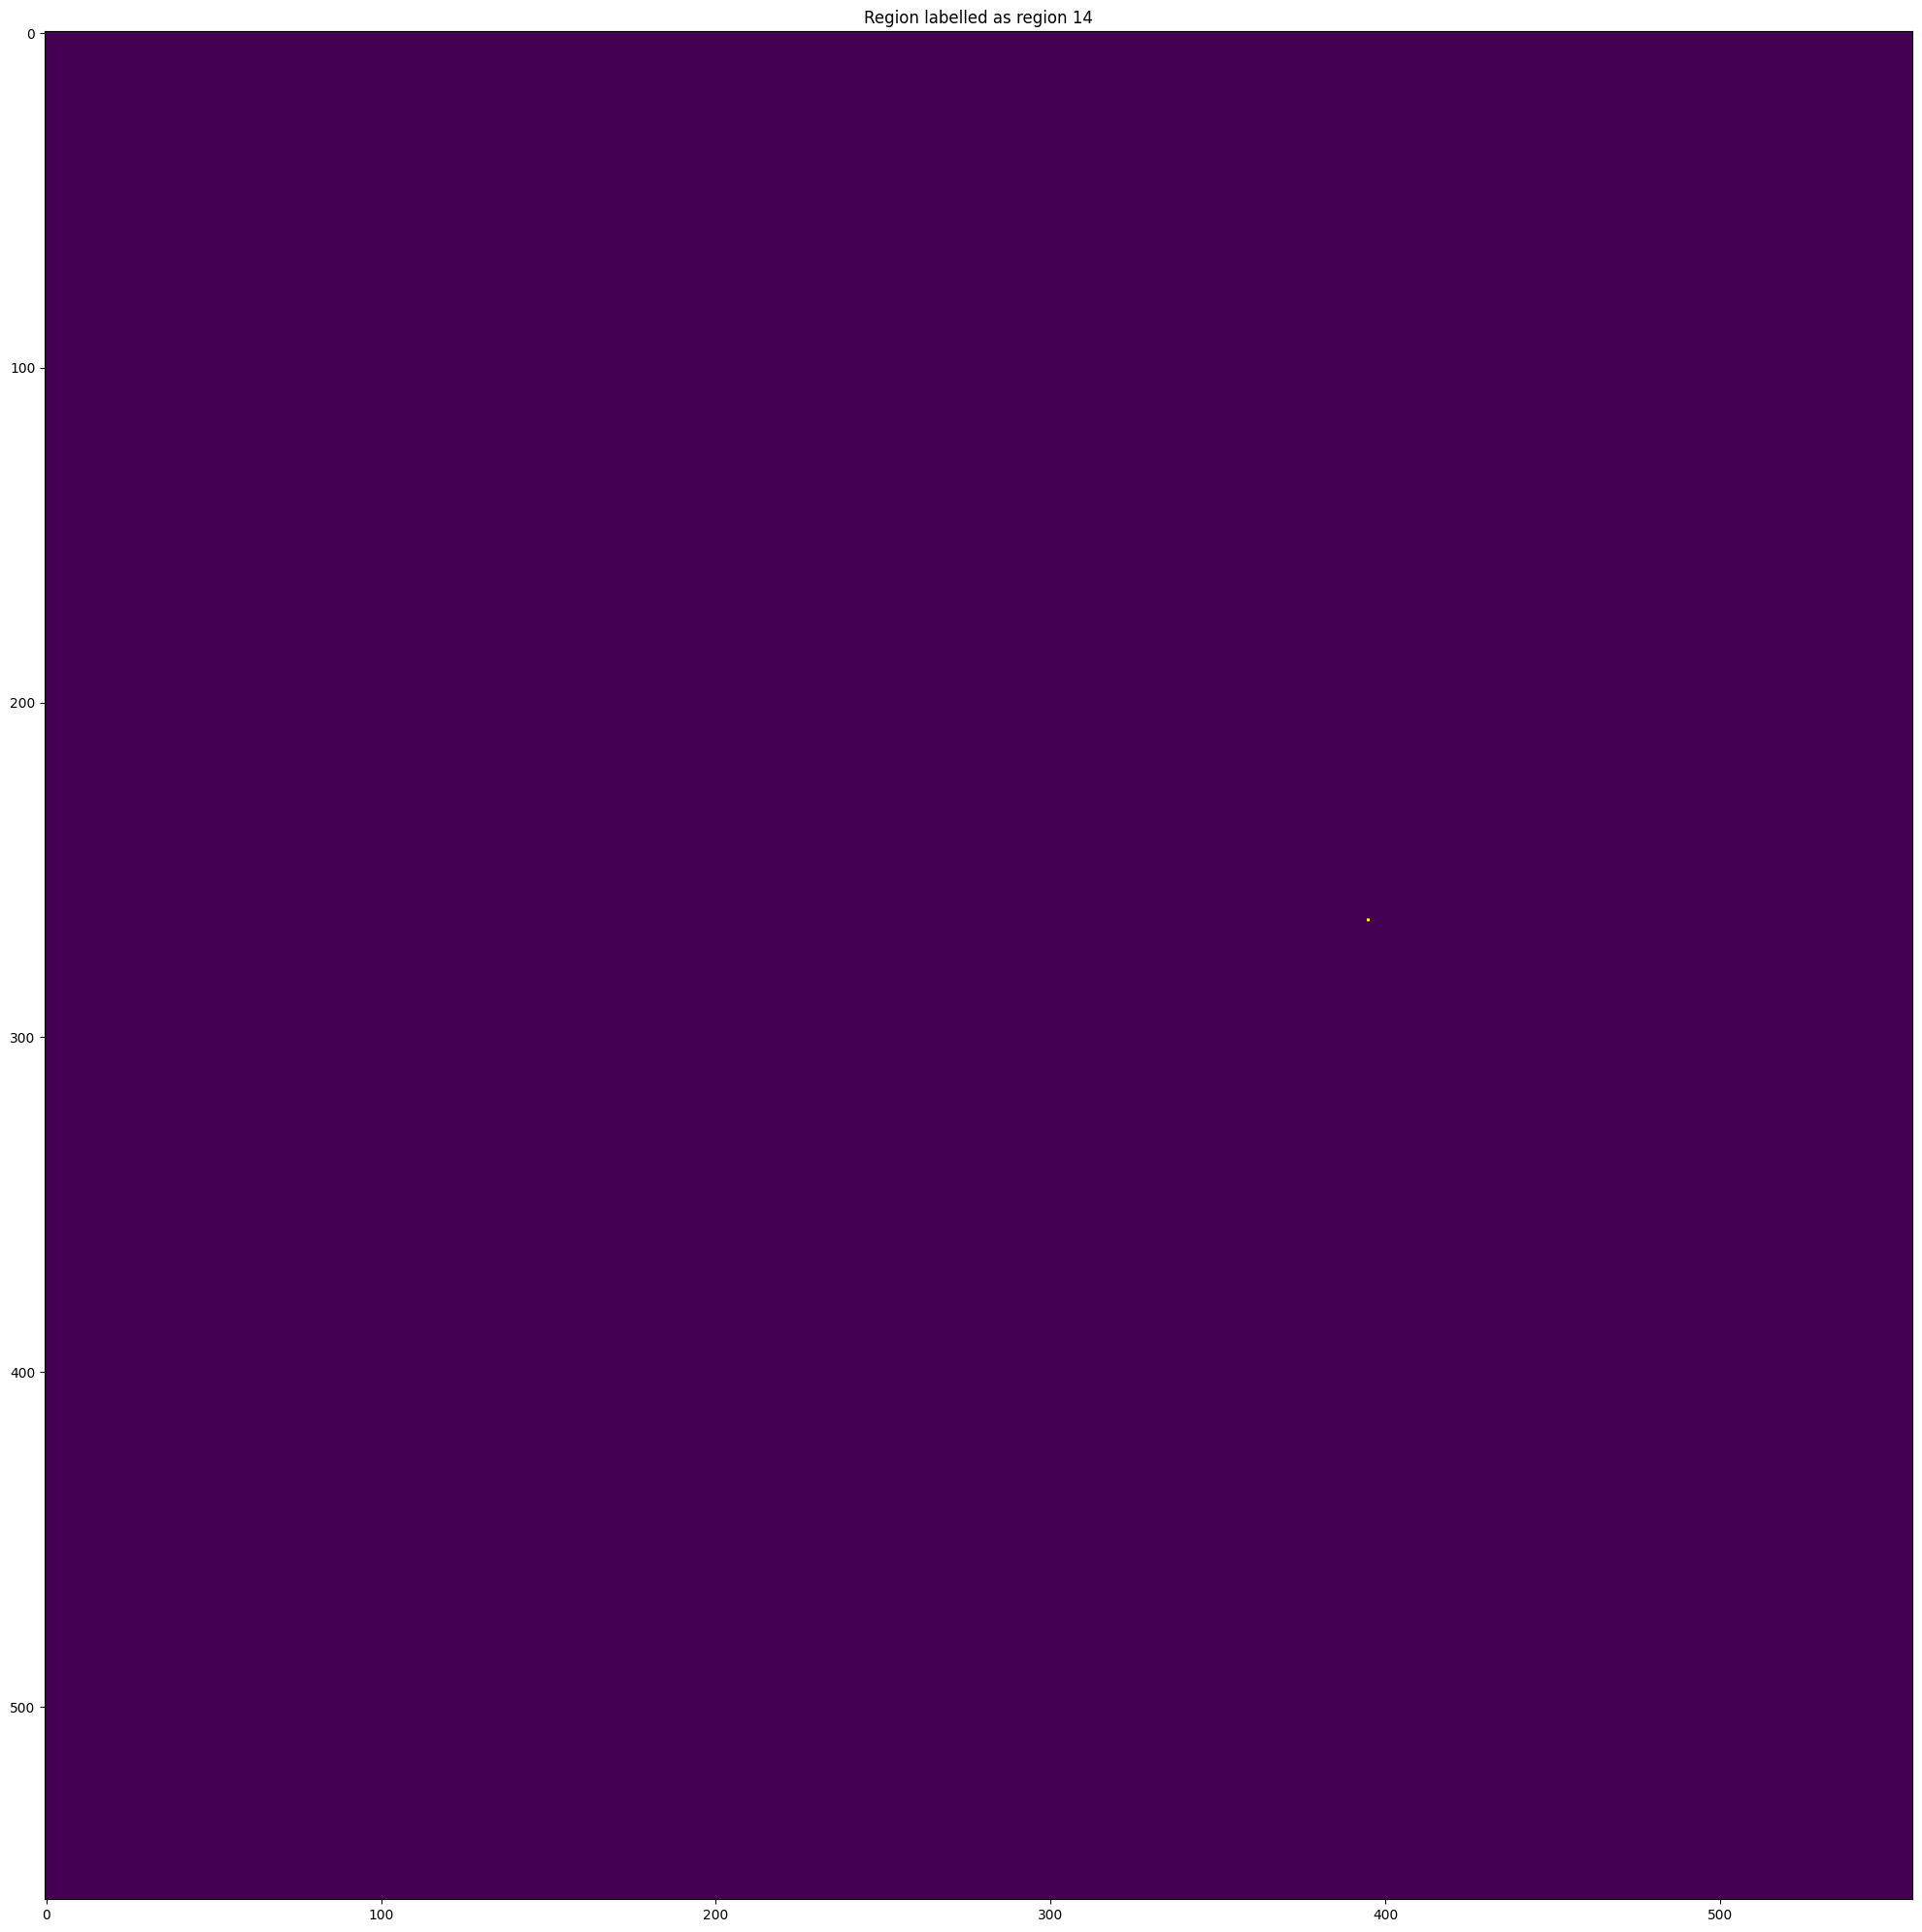

Area of Region 14: 1.0 pixels
Centroiod of Region 14: (np.float64(265.0), np.float64(395.0)) 
Eccentricity of Region 14: 0
Major Axis Length of Region 14: 0.0 pixels
Minor Axis Length of Region 14: 0.0 pixels
Perimeter of Region 14: 0.0 pixels
Orientation of Region 14: -0.7853981633974483 degrees


In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(label_image==14)
ax.set_title('Region labelled as region 14') # set figure title
plt.tight_layout()
plt.show()

print('Area of Region 14: {} pixels'.format(props[13].area))
print('Centroiod of Region 14: {} '.format(props[13].centroid))
print('Eccentricity of Region 14: {}'.format(props[13].eccentricity))
print('Major Axis Length of Region 14: {} pixels'.format(props[13].major_axis_length))
print('Minor Axis Length of Region 14: {} pixels'.format(props[13].minor_axis_length))
print('Perimeter of Region 14: {} pixels'.format(props[13].perimeter))
print('Orientation of Region 14: {} degrees'.format(props[13].orientation))

4. Removal of spourious regions:

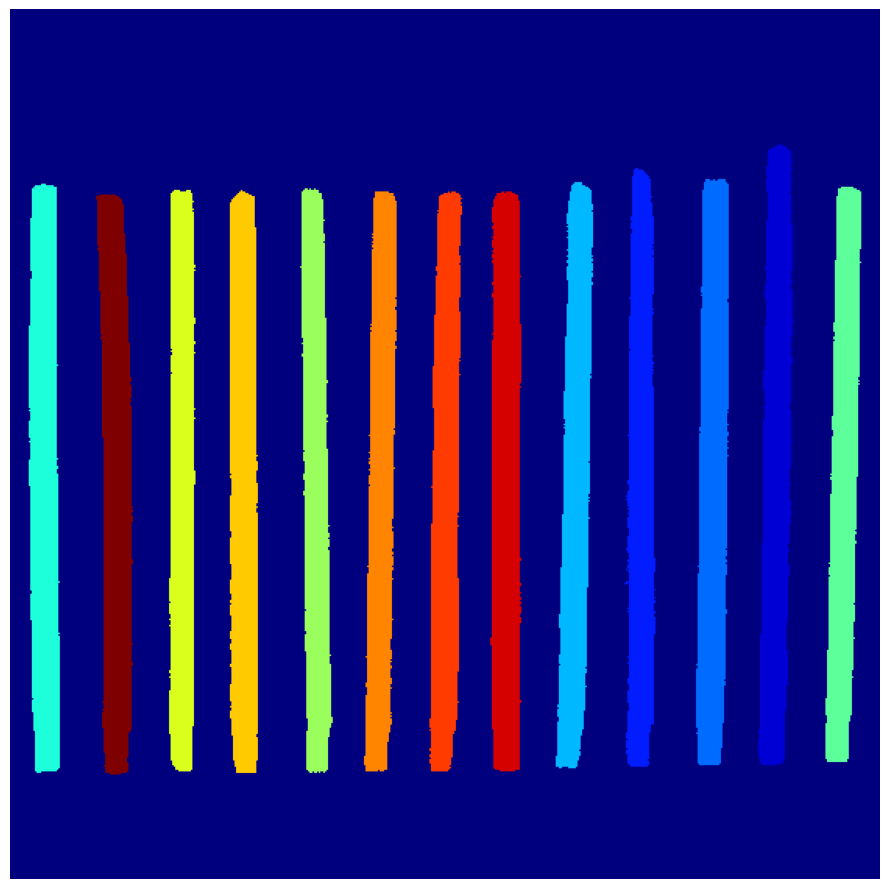

In [20]:
for i in np.squeeze(ind_small): # loop over small (spourious) regions
    iregion = i+1
    label_image[label_image==iregion]=0 # set spourious region as background by re-labelling as zero

image_label_overlay = label2rgb(label_image, image=IG) # generate again the colormap assignment

fig, ax = plt.subplots(figsize=(14, 9))
ax.imshow(label_image,cmap=plt.cm.jet)
ax.set_axis_off()
plt.tight_layout()
plt.show()


5. Obtain final region properties:

The number of final regions is 13


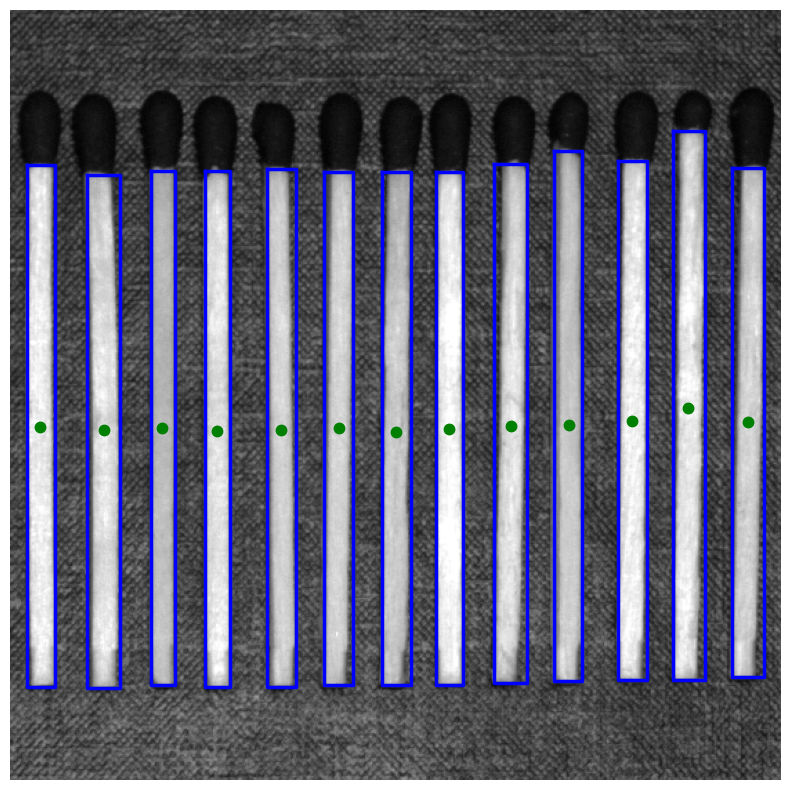

In [21]:
from skimage.measure import regionprops
import math

props = regionprops(label_image) # Obain again the properties after removal of spourious regions
print('The number of final regions is {}'.format(len(props)))

fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(IG, cmap=plt.cm.gray)

for p in props:
    y0, x0 = p.centroid
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = p.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.set_axis_off()
plt.show()


2. Texture-based regional properties

Understanding the gray-level co-ocurrence matrix:

Each component of the co-ocurrence matrix g[i,j,d,theta] represents the number of times that grey-level j occurs at a distance d and at an angle theta from grey-level i:

In [22]:
from skimage.feature.texture import graycomatrix, graycoprops

image = np.array([[0, 0, 1, 1],[0, 0, 1, 1],[0, 2, 2, 2],[2, 2, 3, 3]], dtype=np.uint8)
g = graycomatrix(image, [1], [0], levels=4, normed=False, symmetric=False)
print(image)
print('Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[0,0,0,0]))
print('Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[0,1,0,0]))
print('Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[2,2,0,0]))
print('Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[2,0,0,0]))

[[0 0 1 1]
 [0 0 1 1]
 [0 2 2 2]
 [2 2 3 3]]
Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): 2
Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): 2
Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): 3
Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): 0


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import regionprops
from skimage import data, img_as_ubyte

# Assume that `label_image` and `IG` are already defined
# IG should be a grayscale image of type uint8
# label_image is the label map of regions

props = regionprops(label_image,intensity_image=IG) # Obtain again the properties after removal of spourious regions

nregions = len(props)

iregion = 0
props_texture = np.zeros((nregions,5))
for p in props:
    minr, minc, maxr, maxc = p.bbox
    I = IG[minc:maxc,minr:maxr]
    g = graycomatrix(I, [1], [0], levels=None, normed=True, symmetric=True)
    contrast = graycoprops(g, 'contrast')
    dissimilarity = graycoprops(g, 'dissimilarity')
    homogeneity = graycoprops(g, 'homogeneity')
    energy = graycoprops(g, 'energy')
    correlation = graycoprops(g, 'correlation')

    props_texture[iregion,0] = contrast
    props_texture[iregion,1] = dissimilarity
    props_texture[iregion,2] = homogeneity
    props_texture[iregion,3] = energy
    props_texture[iregion,4] = correlation

    iregion = iregion + 1

# Export to Excel file
df = pd.DataFrame(props_texture, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation'])
df.to_excel("Texture_features.xlsx", index=False)
df

<ipython-input-23-cb68f9e83329>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion,0] = contrast
<ipython-input-23-cb68f9e83329>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion,1] = dissimilarity
<ipython-input-23-cb68f9e83329>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion,2] = homogeneity
<ipython-input-23-cb68f9e83329>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is

,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,193.105465,10.836491,0.094759,0.018133,0.929850
1,345.012533,12.844386,0.111022,0.021629,0.956752
2,333.493460,12.857270,0.102070,0.015937,0.955309
3,327.672222,12.236667,0.113407,0.018564,0.960499
4,128.309947,9.120292,0.102557,0.024563,0.696337
5,188.529773,10.965028,0.086201,0.020034,0.704618
6,307.925770,12.667558,0.098066,0.016163,0.960275
7,154.689753,9.001581,0.141326,0.024024,0.955489
8,284.106643,12.393506,0.092209,0.016595,0.962103
9,337.488897,13.076884,0.108817,0.024348,0.958346


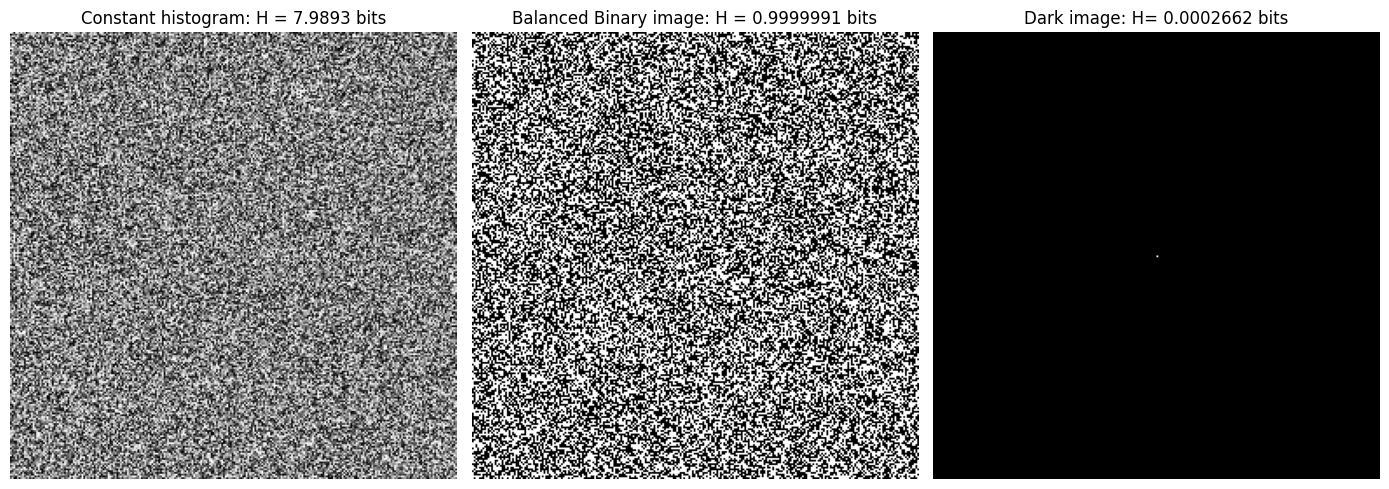

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Image with constant histogram:
I1 = np.random.randint(256,size=(256,256))

# Obtain probability of ocurrence of each grayscale level from image histogram:
v = I1.flatten() # Flatten image as row vector:
probg,edges = np.histogram(v,bins=np.arange(256), density=True)
eps = 1e-16
# Compute Shannon's entropy:
probg = probg + eps
H1 = -np.sum(probg * np.log2(probg), axis=0)

# 2. Binary image with half of the pixels 0 and half 1:
I2 = np.random.randint(2,size=(256,256))

# Obtain probability of ocurrence of each grayscale level from image histogram:
v = I2.flatten() # Flatten image as row vector:
probg,edges = np.histogram(v,bins=np.arange(256), density=True)
eps = 1e-16
# Compute Shannon's entropy:
probg = probg + eps
H2 = -np.sum(probg * np.log2(probg), axis=0)

# 3. Binary image with half of the pixels 0 and half 1:
I3 = np.zeros((256,256))
I3[128,128]=1
# Obtain probability of ocurrence of each grayscale level from image histogram:
v = I3.flatten() # Flatten image as row vector:
probg,edges = np.histogram(v,bins=np.arange(256), density=True)
eps = 1e-16
# Compute Shannon's entropy:
probg = probg + eps
H3 = -np.sum(probg * np.log2(probg), axis=0)

fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(I1,cmap=plt.cm.gray)
ax[0].set_title('Constant histogram: H = {0:1.4f} bits'.format(H1))
ax[1].imshow(I2,cmap=plt.cm.gray)
ax[1].set_title('Balanced Binary image: H = {0:1.7f} bits'.format(H2))
ax[2].imshow(I3,cmap=plt.cm.gray)
ax[2].set_title('Dark image: H= {0:1.7f} bits'.format(H3))

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

Entropy of regions:
Compute entropy of the different objects in the previous segmentation example:


In [25]:
import matplotlib.pyplot as plt
import numpy as np

iregion = 0
entropy = np.zeros(nregions)
for p in props:
    minr, minc, maxr, maxc = p.bbox
    I = IG[minc:maxc,minr:maxr]
    v = I.flatten() # Flatten image as row vector:
    # Probability of ocurrence of each grayscale level
    probg,edges = np.histogram(v,bins=np.arange(256), density=True)
    eps = 1e-16
    probg = probg + eps
    H = -np.sum(probg * np.log2(probg), axis=0) # Compute Shannon's entropy
    entropy[iregion] = H
    iregion = iregion + 1

print('Entropy of the objects: {}'.format(entropy))

Entropy of the objects: [6.77833323 7.22831516 7.31315294 7.21579365 5.85416573 6.17071811
 7.2732025  6.90732055 7.2652201  7.25602906 7.25264207 7.241117
 6.16331812]


**Comparing texture features and Shannon's entropy:**
Comparing the contrast (obtained from the co-ocurrence matrix) and the Shannon's entropy, we observe that regions with a smaller contrast present a decrease in the Shannon's entroppy and therefore can be easily compressed by encoding their pixels with a lower number of bits.

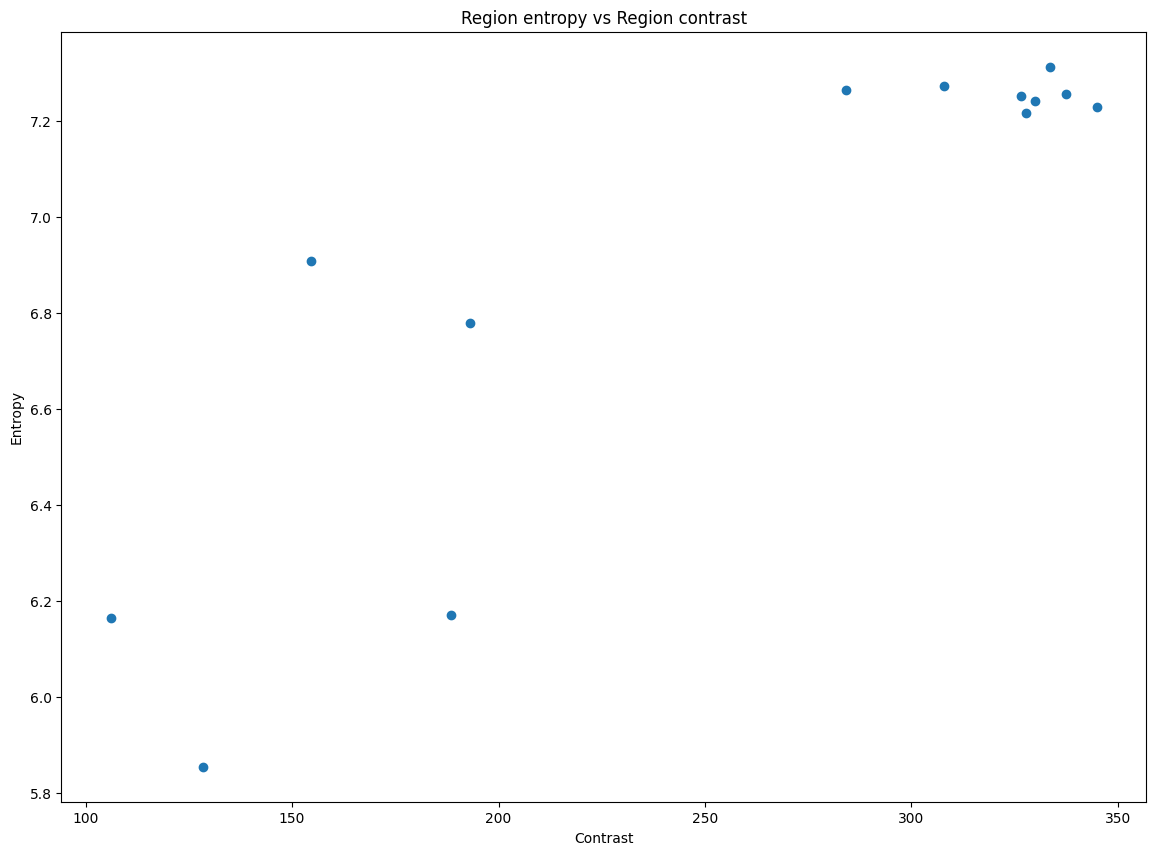

In [26]:
fig = plt.figure(figsize=(14, 10))
plt.scatter(props_texture[:,0], entropy)
plt.ylabel('Entropy')
plt.xlabel('Contrast')
plt.title("Region entropy vs Region contrast")
plt.show()
